In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

DATAPATH = 'NSEI.csv'

data = pd.read_csv(DATAPATH, index_col=['Date'], parse_dates=['Date'])
data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-11-28,8516.799805,8617.000000,8516.250000,8588.250000,8588.250000,197200.0
2014-12-01,8605.099609,8623.000000,8545.150391,8555.900391,8555.900391,152000.0
2014-12-02,8535.450195,8560.200195,8504.650391,8524.700195,8524.700195,137400.0
2014-12-03,8528.700195,8546.950195,8508.349609,8537.650391,8537.650391,153200.0
2014-12-04,8582.400391,8626.950195,8526.400391,8564.400391,8564.400391,143500.0
2014-12-05,8584.250000,8588.349609,8523.900391,8538.299805,8538.299805,143300.0
2014-12-08,8538.650391,8546.349609,8432.250000,8438.250000,8438.250000,163800.0
2014-12-09,8439.299805,8444.500000,8330.500000,8340.700195,8340.700195,146300.0
2014-12-10,8318.049805,8376.799805,8317.000000,8355.650391,8355.650391,136700.0


In [2]:
data = data[data.Close != 'null']
data = data[data.Close.notnull()]
drop_cols = ['Open','High','Low','Adj Close','Volume']

data.drop(drop_cols, axis=1, inplace=True)

data.head()

,Close
Date,
2014-11-28,8588.250000
2014-12-01,8555.900391
2014-12-02,8524.700195
2014-12-03,8537.650391
2014-12-04,8564.400391


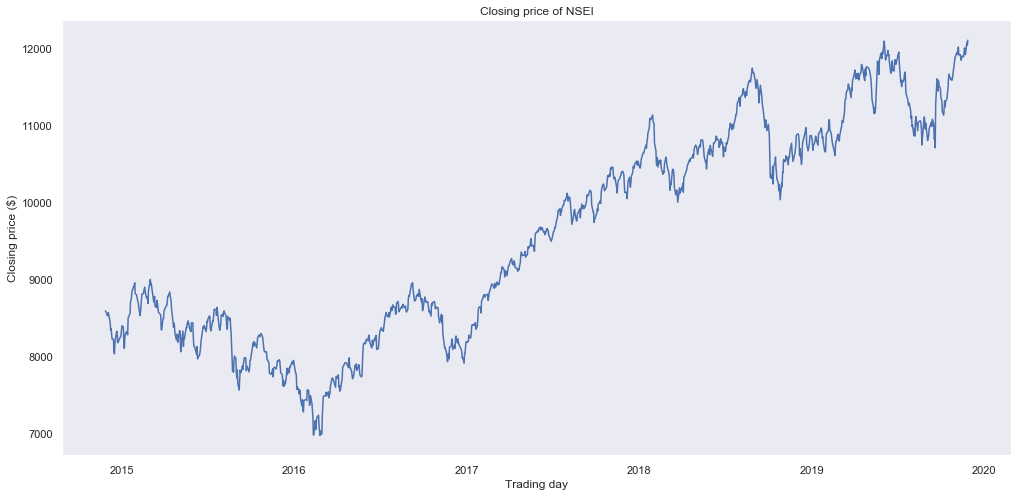

In [3]:
# Plot closing price

plt.figure(figsize=(17, 8))
plt.plot(data.Close)
plt.title('Closing price of NSEI')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

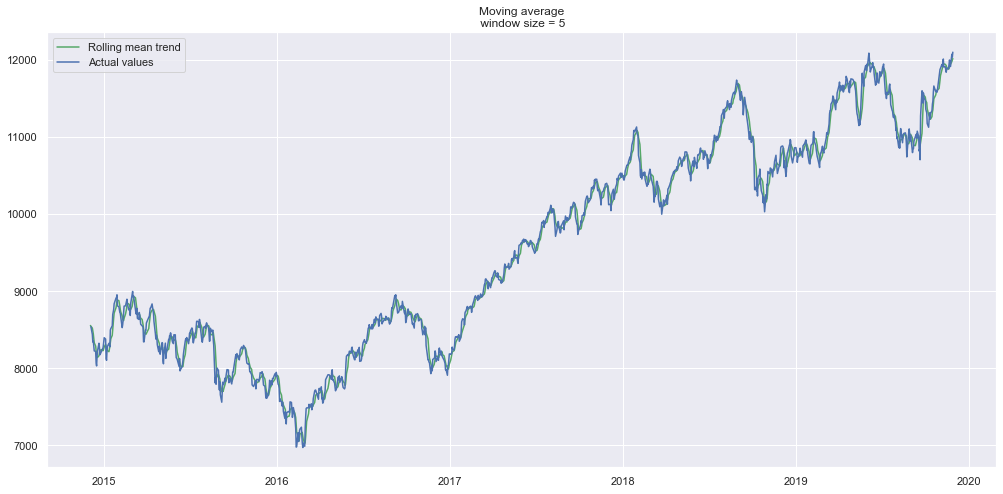

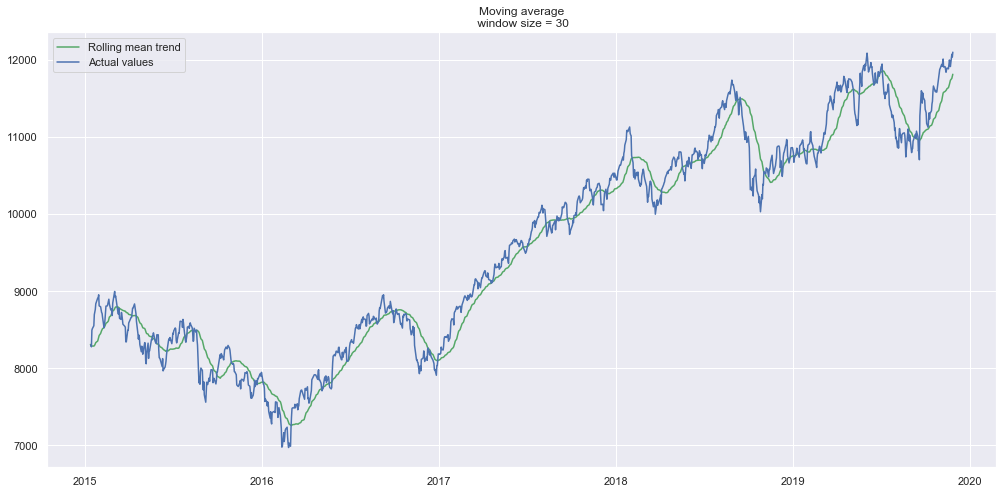

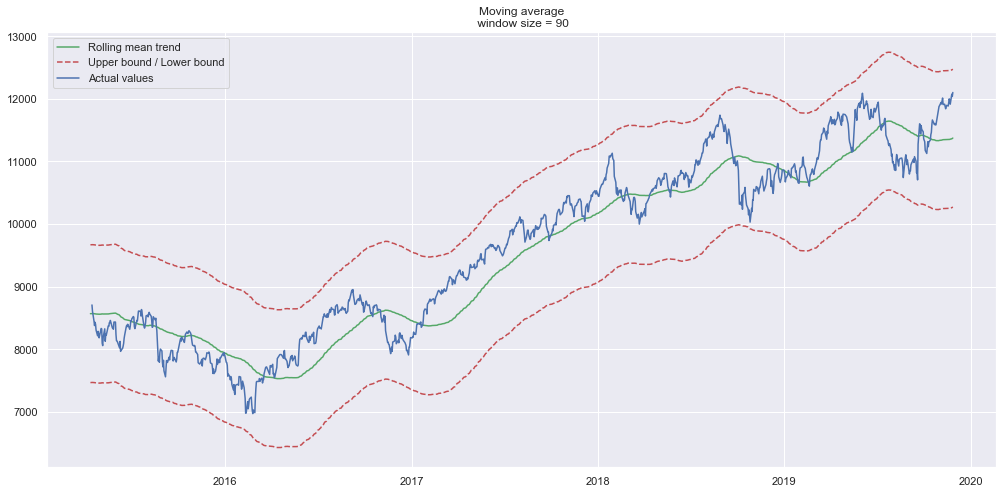

In [4]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(data.Close, 5)

#Smooth by the previous month (30 days)
plot_moving_average(data.Close, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(data.Close, 90, plot_intervals=True)

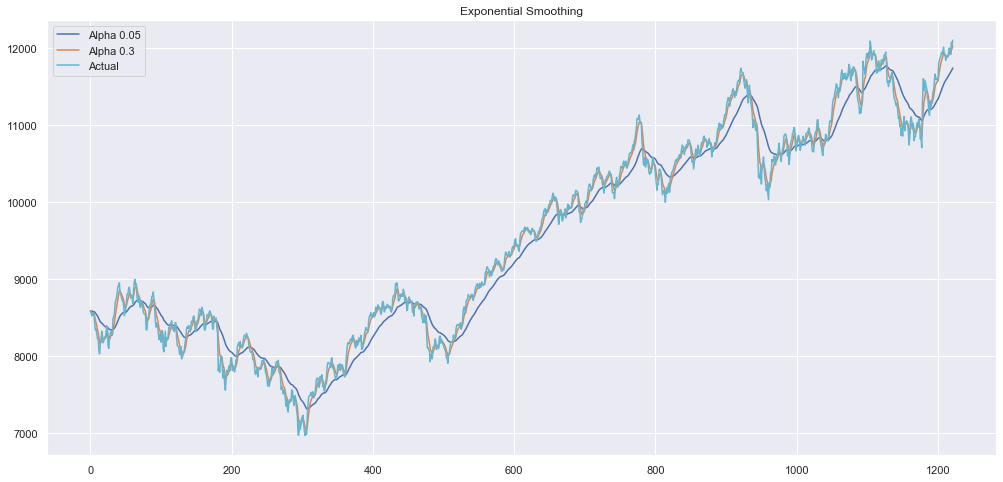

In [5]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(data.Close, [0.05, 0.3])

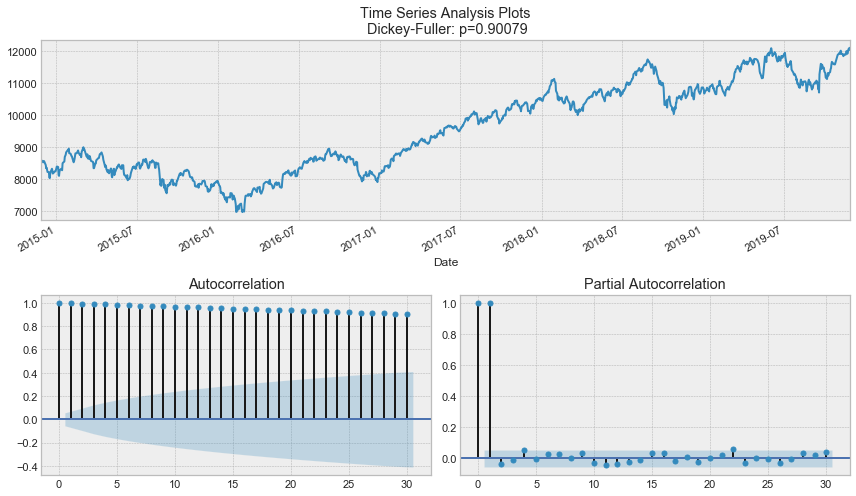

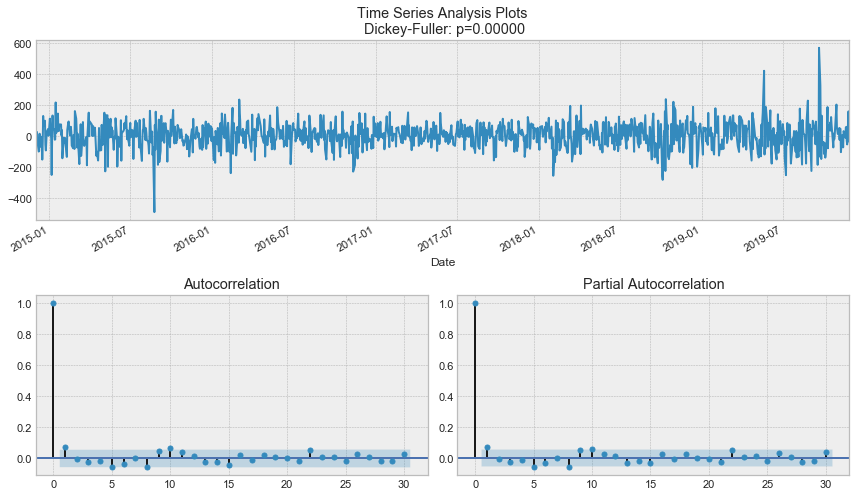

In [6]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.Close, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = data.Close - data.Close.shift(1)

tsplot(data_diff[1:], lags=30)

In [7]:
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data.Close, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data.Close, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())


                                 Statespace Model Results                                
Dep. Variable:                             Close   No. Observations:                 1222
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 5)   Log Likelihood               -7081.341
Date:                           Thu, 28 Nov 2019   AIC                          14172.682
Time:                                   19:47:21   BIC                          14198.198
Sample:                                        0   HQIC                         14182.287
                                          - 1222                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0617      0.022      2.838      0.005       0.019       0.104
ar.S.L5       -0.0514      0.027     -1.90

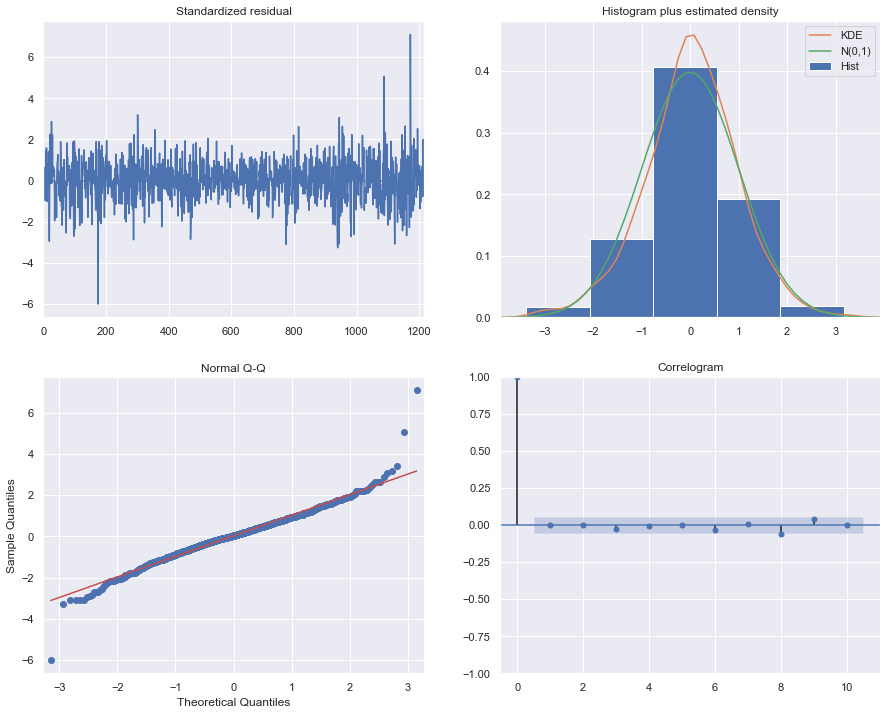

In [39]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [46]:
pred_uc = best_model.get_forecast(steps=5)

In [48]:
y_forecasted = pred_uc.predicted_mean
y_forecasted.head(5)

1222    12106.647849
1223    12120.105934
1224    12118.300175
1225    12125.115029
1226    12123.702179
dtype: float64

In [50]:
pred = best_model.get_prediction(start=pd.to_datetime('2019-11-25'), dynamic=False)

In [60]:
y_forecasted = pred.predicted_mean
print(y_forecasted.head(12))
print(data.Close[1221])

Date
2019-11-25    11911.482389
2019-11-26    12083.122126
2019-11-27    12025.827595
dtype: float64
12100.700195
